# Teacher Model
This notebook trains the ResNext29_16x64d teacher model. 
The reference paper mentions that the teacher model they used was trained using label smoothing and cosine learning rate decay. 
The same is done here, but, as seen before on ResNet56 v1 for CIFAR100, the warmup period is increased to T=20 to see if that improves the results of the teacher model, and later, on the student which the teacher trains. 

The parameters of the teacher model is saved to a .parmas file.

The time it takes to train this specific teacher model is roughly ~10 hours....

In [1]:
from __future__ import division

import argparse, time, logging, random, math, os, sys

import numpy as np
import mxnet as mx
import gluoncv as gcv

from datetime import datetime
from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory, LRSequential, LRScheduler
from gluoncv.data import transforms as gcv_transforms
print("Imports successful")

Imports successful


In [2]:
per_device_batch_size = 64 # Batch Size for Each GPU
num_workers = 2             # Number of data loader workers
dtype = 'float32'           # Default training data type if float32
num_gpus = 1                # number of GPUs to use
batch_size = per_device_batch_size * num_gpus # Calculate effective total batch size

# For CIFAR100 Dataset:
num_classes = 100
num_images_per_class = 500
num_training_samples = num_classes * num_images_per_class
num_batches = num_training_samples // batch_size

## Smoothing

In [3]:
label_smoothing = True
def smooth(label, num_classes, eta=0.1):
    if isinstance(label, nd.NDArray):
        print("Label changed to list")
        label = [label]
    smoothed = []
    for l in label:
        res = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                     off_value = eta/num_classes)
        smoothed.append(res)
    return smoothed
print("\nUsing label smoothing: {}".format(label_smoothing))


Using label smoothing: True


## Mixup

In [4]:
mixup = False
def mixup_transform(label, num_classes, lam=1, eta=0.0):
    if isinstance(label, nd.NDArray):
        print("Label changed to list")
        label = [label]
    res = []
    for l in label:
        y1 = l.one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                    off_value = eta/num_classes)
        y2 = l[::-1].one_hot(num_classes, on_value = 1 - eta + eta/num_classes, 
                                          off_value = eta/num_classes)
        res.append(lam*y1 + (1-lam)*y2)
    return res
print("Using mixup: {}".format(mixup))

Using mixup: False


# Model Init

In [5]:
ctx = [mx.gpu(i) for i in range(num_gpus)]

# last_gamma = False
# print("Using last gamma: {}".format(last_gamma))
# kwargs = {'ctx':ctx, 'classes':num_classes, 'last_gamma':last_gamma}

kwargs = {'ctx':ctx, 'classes':num_classes}

use_group_norm = False
if use_group_norm:
    kwargs['norm_layer'] = gcv.nn.GroupNorm
    print("Using Group Normalization: {}".format(use_group_norm))

default_init = True
net = get_model('cifar_resnext29_16x64d', **kwargs)

if default_init:
    net.initialize(mx.init.Xavier(), ctx = ctx)
else:
    net.initialize(mx.init.MSRAPrelu(), ctx=ctx)
    print("Using MSRA Prelu Init.")

    net.cast(dtype)
print("\nModel Init Done.")


Model Init Done.


In [6]:
resize = 32
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
max_aspect_ratio = 4.0 / 3.0
min_aspect_ratio = 3.0 / 4.0
max_random_area = 1
min_random_area = 0.08
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([    
#     transforms.RandomResizedCrop(resize,
#                                  scale=(min_random_area, max_random_area), 
#                                  ratio=(min_aspect_ratio, max_aspect_ratio)),
    
        # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    
    transforms.RandomBrightness(brightness=jitter_param),
    transforms.RandomSaturation(saturation=jitter_param),
    transforms.RandomHue(hue=jitter_param),
    
    transforms.RandomLighting(lighting_param),
    
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
        
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize(mean_rgb, std_rgb),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb),
])
print("Preprocessing Step Successful.")

Preprocessing Step Successful.


# Compose Image Transforms

In [7]:
# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=True).transform_first(transform_train),
    batch_size=batch_size, 
    shuffle=True, 
    last_batch='discard', 
    num_workers=num_workers)

# Set train=False for validation data
# Set shuffle=False to shuffle the testing data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=False).transform_first(transform_test),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)
print("Initialization of train_data and val_data successful.")
print("Per Device Batch Size: {}".format(per_device_batch_size))

Initialization of train_data and val_data successful.
Per Device Batch Size: 64


# Training Settings

In [8]:
if mixup:
    epochs = 200 # Mixup asks for longer training to converge better
else:
#     epochs = 120
    epochs = 1
    
warmup_epochs = 20
mixup_off_epochs = 0

alpha = 0.2 # For Beta distribution sampling

lr_decay_epochs = [30, 60, 90, np.inf] # Epochs where learning rate decays
# lr_decay_epochs = [40, 80]

warmup_lr_mode = 'linear'
lr_mode = 'cosine'
lr_decay = 0.1 # Learning rate decay factor
target_lr = 0

# Sets up a linear warmup scheduler, followed by a cosine rate decay.
# Consult the paper for the proper parameters (base_lr, target_lr, warmup_epochs, etc.)
lr_scheduler = LRSequential([
    LRScheduler(warmup_lr_mode,
                base_lr = 0,
                target_lr = 0.1,
                nepochs = warmup_epochs,
                iters_per_epoch = num_batches),
    
    LRScheduler(lr_mode,
                base_lr = 0.1,
                target_lr = target_lr,
                nepochs = epochs - warmup_epochs,
                iters_per_epoch = num_batches,
                step_epoch = lr_decay_epochs,
                step_factor = lr_decay,
                power = 2)
])

# Nesterov accelerated gradient descent and set parameters (based of off 
# reference papers and default values):
optimizer = 'nag'
optimizer_params = {'lr_scheduler': lr_scheduler, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

if label_smoothing or mixup:
    sparse_label_loss = False
else:
    sparse_label_loss = True

print("sparse label loss: {}".format(sparse_label_loss))

loss_fn = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=sparse_label_loss)

train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])
train_history2 = TrainingHistory(['training-acc', 'val-acc-top1', 'val-acc-top5'])

print("\nUsing label smoothing: {}".format(label_smoothing))
print("Using mixup: {}".format(mixup))

print("\nUsing {} Optimizer".format(optimizer))
print(optimizer_params)
print("\nNumber of warmup epochs: {}".format(warmup_epochs))
print("Warmup Learning Rate Mode: {}".format(warmup_lr_mode))
print("Learing Rate Mode: {}".format(lr_mode))
print("Learing Rate Decay: {}".format(lr_decay))
print("Learning Rate Decay Epochs: {}".format(lr_decay_epochs))
print("\nTraining Settings Set Successfully.")

sparse label loss: False

Using label smoothing: True
Using mixup: False

Using nag Optimizer
{'lr_scheduler': <gluoncv.utils.lr_scheduler.LRSequential object at 0x7fe79ed84c90>, 'wd': 0.0001, 'momentum': 0.9}

Number of warmup epochs: 5
Warmup Learning Rate Mode: linear
Learing Rate Mode: cosine
Learing Rate Decay: 0.1
Learning Rate Decay Epochs: [30, 60, 90, inf]

Training Settings Set Successfully.


# Test Function

In [9]:
acc_top1 = mx.metric.Accuracy()
acc_top5 = mx.metric.TopKAccuracy(5)

def test(ctx, val_data):
    acc_top1.reset()
    acc_top5.reset()
    
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X.astype(dtype, copy=False)) for X in data]
        acc_top1.update(label, outputs)
        acc_top5.update(label, outputs)
    
    _, top1 = acc_top1.get()
    _, top5 = acc_top5.get()
    
    return (top1, top5)

# Training Loop

Training loop started for 1 epochs:
[Epoch 0] train=0.172775 val_top1=0.308900 val_top5=0.681300 loss=161583.934113 time: 300.703773
Done.


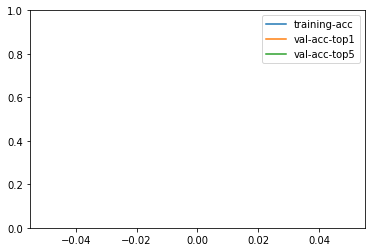

In [10]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])
train_history2 = TrainingHistory(['training-acc', 'val-acc-top1', 'val-acc-top5'])

print("Training loop started for {} epochs:".format(epochs))
for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        if mixup:
            lam = np.random.beta(alpha, alpha)
            if epoch >= epochs - mixup_off_epochs:
                lam = 1
            data = [lam*X + (1-lam)*X[::-1] for X in data]
            
            if label_smoothing:
                eta = 0.1
            else:
                eta = 0.0

            label = mixup_transform(label, num_classes, lam, eta)
        
        elif label_smoothing:
            hard_label = label
            label = smooth(label, num_classes)
        
        # AutoGrad
        with ag.record():
            outputs = [net(X.astype(dtype, copy=False)) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(outputs, label)]
            
        # Backpropagation
        for l in loss:
            l.backward()
        
        train_loss += sum([l.sum().asscalar() for l in loss])
            
        # Optimize
        trainer.step(batch_size)
        
        # Update metrics
        if mixup:
            output_softmax = [nd.SoftmaxActivation(out.astype(dtype, copy=False)) \
                              for out in outputs]
            train_metric.update(label, output_softmax)
        else:
            if label_smoothing:
                train_metric.update(hard_label, outputs)
            else:
                train_metric.update(label, outputs)

    name, acc = train_metric.get()
    
    # Evaluate on Validation data
    #name, val_acc = test(ctx, val_data)
    val_acc_top1, val_acc_top5 = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc_top1])
    train_history2.update([acc, val_acc_top1, val_acc_top5])
    
    print('[Epoch %d] train=%f val_top1=%f val_top5=%f loss=%f time: %f' %
        (epoch, acc, val_acc_top1, val_acc_top5, train_loss, time.time()-tic))

# We can plot the metric scores with:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
train_history.plot(['training-error', 'validation-error'], 
                   save_path="./cifar100_resnet56_v1_{o}_{ep}epochs_errors_{t}.png".format(o=optimizer,
                                                                                           ep=epochs,
                                                                                           t=timestamp))
train_history2.plot(['training-acc', 'val-acc-top1', 'val-acc-top5'],
                   save_path="./cifar100_resnet56_v1_{o}_{ep}epochs_accuracies_{t}.png".format(o=optimizer,
                                                                                               ep=epochs,
                                                                                               t=timestamp))
print("Done.")

# Save Net and Parameters to a File

In [11]:
filename = os.path.join(os.getcwd(), "resnext29_teacher.params")
net.save_parameters(filename)
print("Teacher Parameters saved to {}".format(filename))

print("Saved.")

Teacher Parameters saved to /home/ubuntu/ECE6258_Project/scripts/resnext29_teacher.params
Saved.


# Practice Loading Model Params
Will have to do this when using this CNN model for distillation training with the CIFAR_ResNet56_v1 model

In [13]:
teacher_name = 'cifar_resnext29_16x64d'
teacher = get_model(teacher_name, classes=num_classes, ctx=ctx)
teacher.load_parameters(filename)

teacher.cast(dtype)
print(teacher.output)

Dense(1024 -> 100, linear)
